# Potato Disease Dataset Exploration

This notebook explores the potato disease classification dataset.

**Classes:**
- Healthy
- Early Blight
- Late Blight

In [1]:
import sys
print("Python executable:", sys.executable)
print("Python version:", sys.version)
print("Python path:", sys.path[:3])
sys.path.append('../src')

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from torchvision import transforms
import random

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Set random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Python executable: /opt/homebrew/Cellar/jupyterlab/4.3.5_1/libexec/bin/python
Python version: 3.13.2 (main, Feb  4 2025, 14:51:09) [Clang 16.0.0 (clang-1600.0.26.6)]
Python path: ['/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python313.zip', '/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13', '/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/lib-dynload']


## 1. Dataset Statistics

In [2]:
# Dataset path
data_dir = Path('../data')

# Class names
class_names = ['Healthy', 'Early_Blight', 'Late_Blight']
splits = ['train', 'validation', 'test']

# Count images
stats = {}
for split in splits:
    stats[split] = {}
    for class_name in class_names:
        class_dir = data_dir / split / class_name
        if class_dir.exists():
            n_images = len(list(class_dir.glob('*')))
            stats[split][class_name] = n_images
        else:
            stats[split][class_name] = 0

# Print statistics
print("Dataset Statistics")
print("=" * 60)
for split in splits:
    print(f"\n{split.capitalize()}:")
    total = 0
    for class_name in class_names:
        count = stats[split][class_name]
        total += count
        print(f"  {class_name:15s}: {count:4d} images")
    print(f"  {'Total':15s}: {total:4d} images")

Dataset Statistics

Train:
  Healthy        :  106 images
  Early_Blight   :  700 images
  Late_Blight    :  700 images
  Total          : 1506 images

Validation:
  Healthy        :   22 images
  Early_Blight   :  150 images
  Late_Blight    :  150 images
  Total          :  322 images

Test:
  Healthy        :   24 images
  Early_Blight   :  150 images
  Late_Blight    :  150 images
  Total          :  324 images


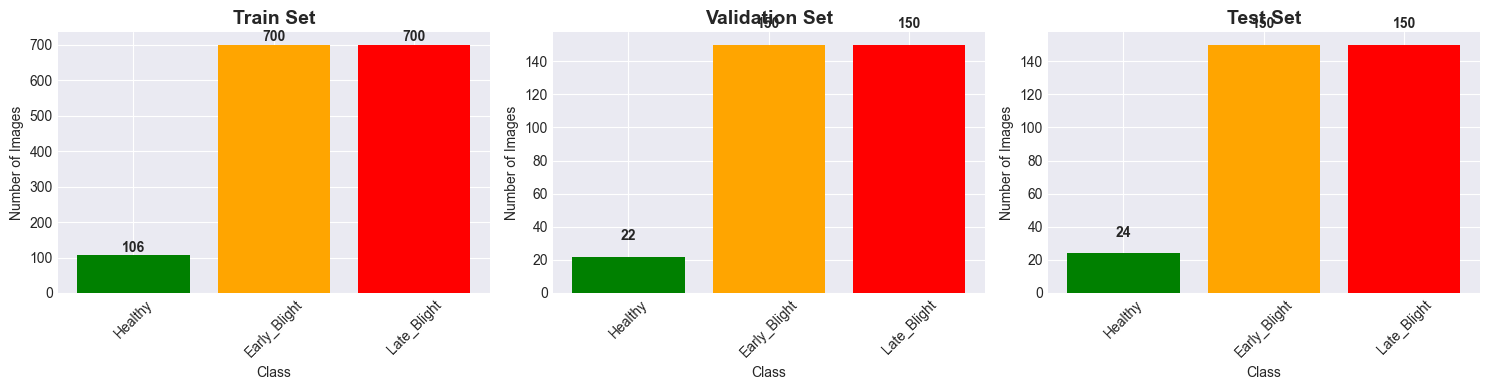

In [3]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, split in enumerate(splits):
    counts = [stats[split][class_name] for class_name in class_names]
    axes[idx].bar(class_names, counts, color=['green', 'orange', 'red'])
    axes[idx].set_title(f'{split.capitalize()} Set', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Number of Images')
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(counts):
        axes[idx].text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Sample Images Visualization

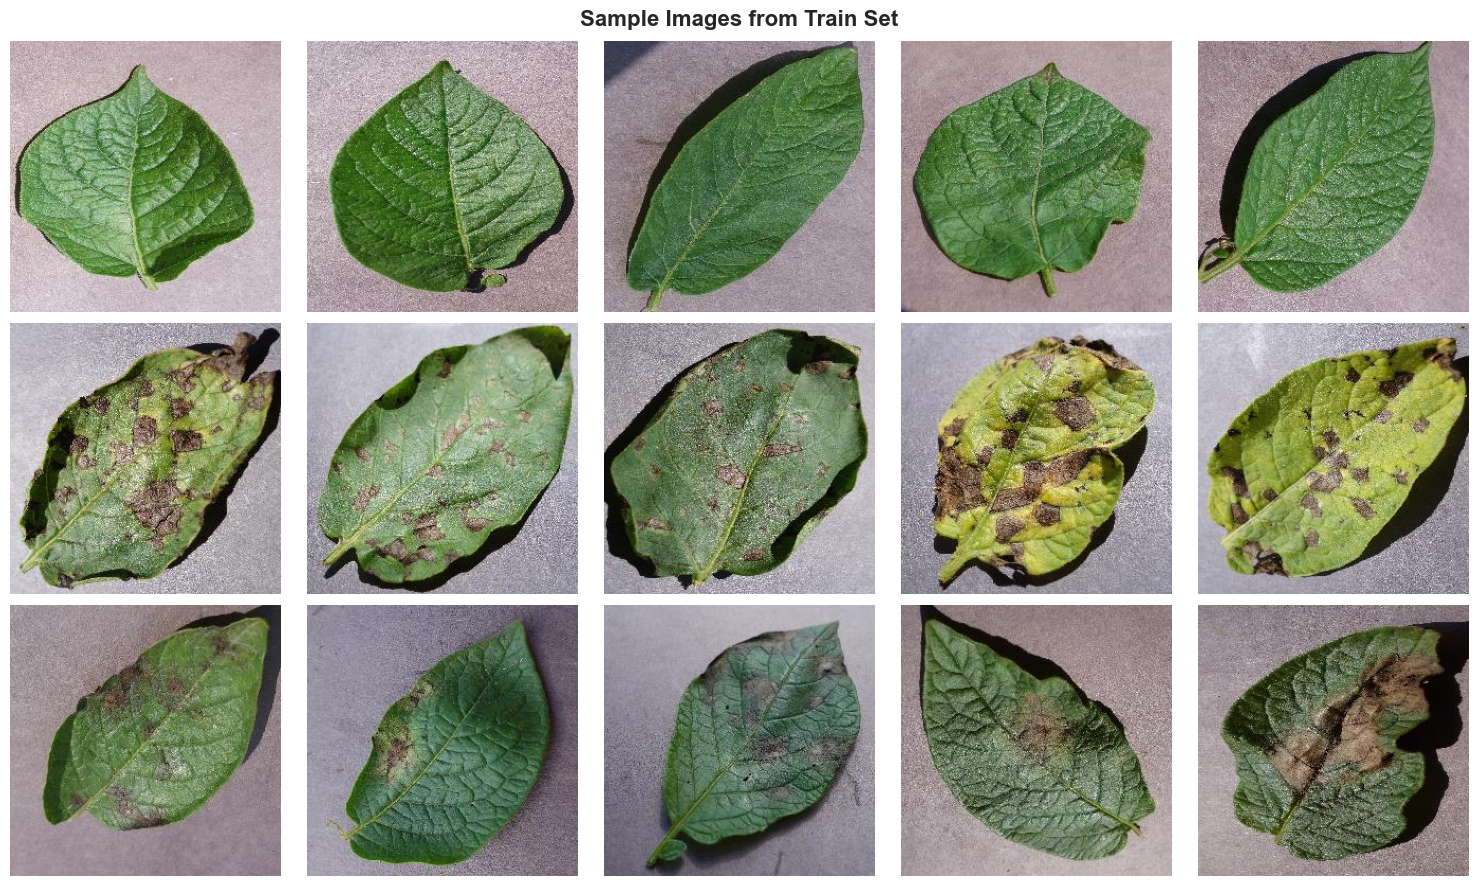

In [4]:
def show_sample_images(data_dir, split='train', n_samples=5):
    """
    Display sample images from each class
    """
    fig, axes = plt.subplots(len(class_names), n_samples, figsize=(15, 9))
    
    for i, class_name in enumerate(class_names):
        class_dir = data_dir / split / class_name
        images = list(class_dir.glob('*'))[:n_samples]
        
        for j, img_path in enumerate(images):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            
            if j == 0:
                axes[i, j].set_ylabel(class_name, fontsize=12, fontweight='bold')
    
    plt.suptitle(f'Sample Images from {split.capitalize()} Set', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

show_sample_images(data_dir, split='train', n_samples=5)

## 3. Image Properties Analysis

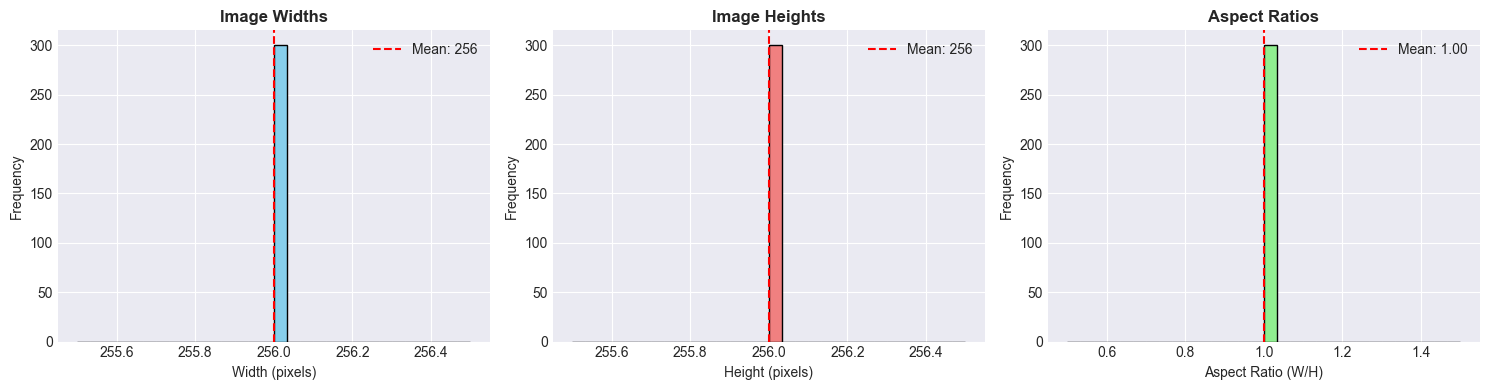

Image Dimensions Summary:
  Width: 256 - 256 (mean: 256)
  Height: 256 - 256 (mean: 256)
  Aspect Ratio: 1.00 - 1.00 (mean: 1.00)


In [5]:
def analyze_image_properties(data_dir, split='train', n_samples=100):
    """
    Analyze image dimensions and properties
    """
    widths = []
    heights = []
    aspect_ratios = []
    
    for class_name in class_names:
        class_dir = data_dir / split / class_name
        images = list(class_dir.glob('*'))[:n_samples]
        
        for img_path in images:
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h)
    
    # Plot distributions
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].hist(widths, bins=30, color='skyblue', edgecolor='black')
    axes[0].set_title('Image Widths', fontweight='bold')
    axes[0].set_xlabel('Width (pixels)')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(np.mean(widths), color='red', linestyle='--', label=f'Mean: {np.mean(widths):.0f}')
    axes[0].legend()
    
    axes[1].hist(heights, bins=30, color='lightcoral', edgecolor='black')
    axes[1].set_title('Image Heights', fontweight='bold')
    axes[1].set_xlabel('Height (pixels)')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(np.mean(heights), color='red', linestyle='--', label=f'Mean: {np.mean(heights):.0f}')
    axes[1].legend()
    
    axes[2].hist(aspect_ratios, bins=30, color='lightgreen', edgecolor='black')
    axes[2].set_title('Aspect Ratios', fontweight='bold')
    axes[2].set_xlabel('Aspect Ratio (W/H)')
    axes[2].set_ylabel('Frequency')
    axes[2].axvline(np.mean(aspect_ratios), color='red', linestyle='--', label=f'Mean: {np.mean(aspect_ratios):.2f}')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Image Dimensions Summary:")
    print(f"  Width: {np.min(widths):.0f} - {np.max(widths):.0f} (mean: {np.mean(widths):.0f})")
    print(f"  Height: {np.min(heights):.0f} - {np.max(heights):.0f} (mean: {np.mean(heights):.0f})")
    print(f"  Aspect Ratio: {np.min(aspect_ratios):.2f} - {np.max(aspect_ratios):.2f} (mean: {np.mean(aspect_ratios):.2f})")

analyze_image_properties(data_dir, split='train', n_samples=100)

## 4. Data Augmentation Visualization

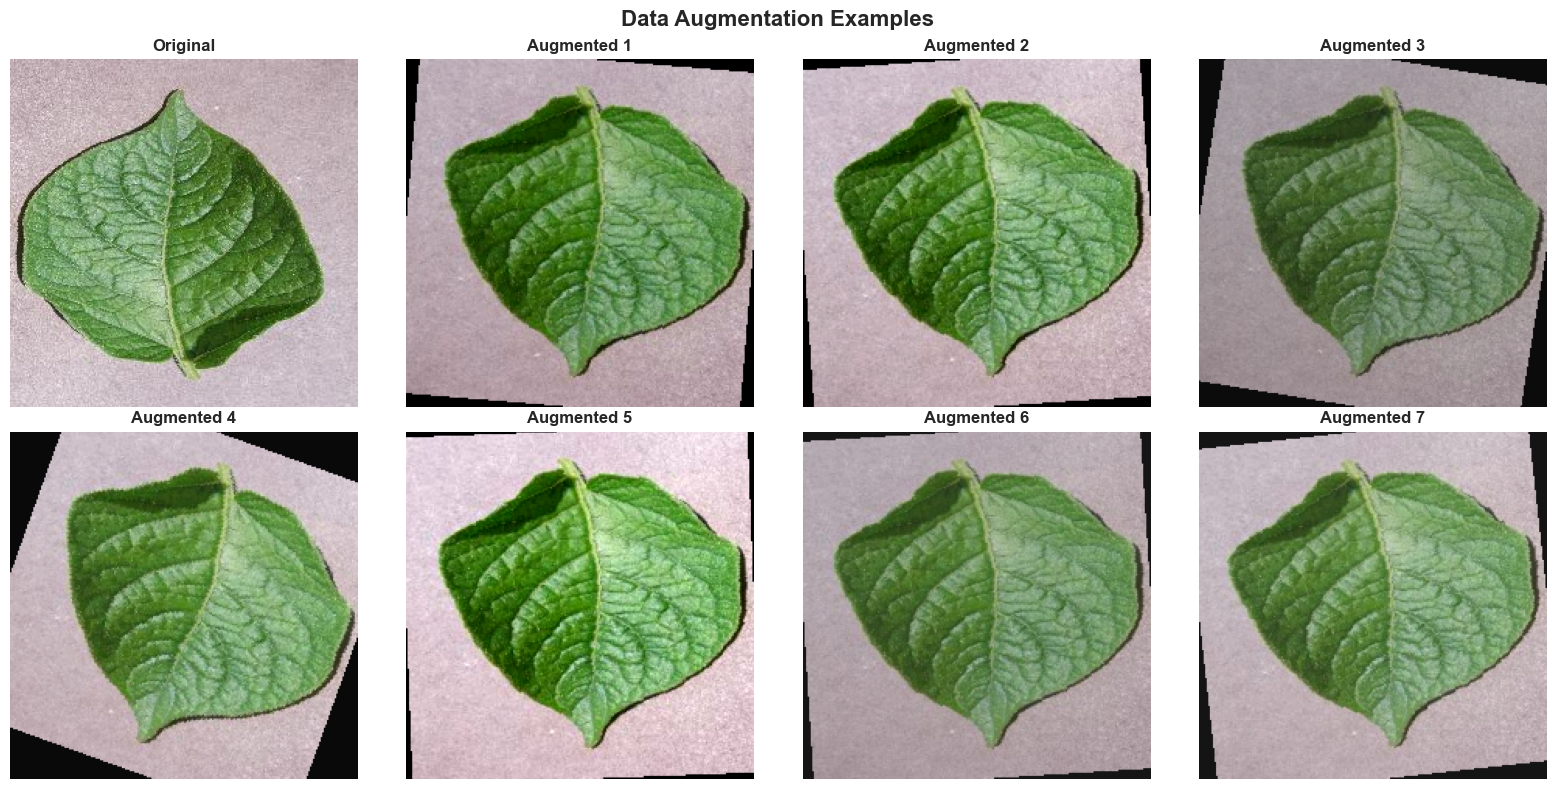

In [6]:
# Define augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

# Load a sample image
sample_dir = data_dir / 'train' / class_names[0]
sample_img_path = list(sample_dir.glob('*'))[0]
original_img = Image.open(sample_img_path)

# Apply augmentations
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Original
axes[0].imshow(original_img)
axes[0].set_title('Original', fontweight='bold')
axes[0].axis('off')

# Augmented versions
for i in range(1, 8):
    augmented_img = augmentation_transform(original_img)
    axes[i].imshow(augmented_img)
    axes[i].set_title(f'Augmented {i}', fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Color Distribution Analysis

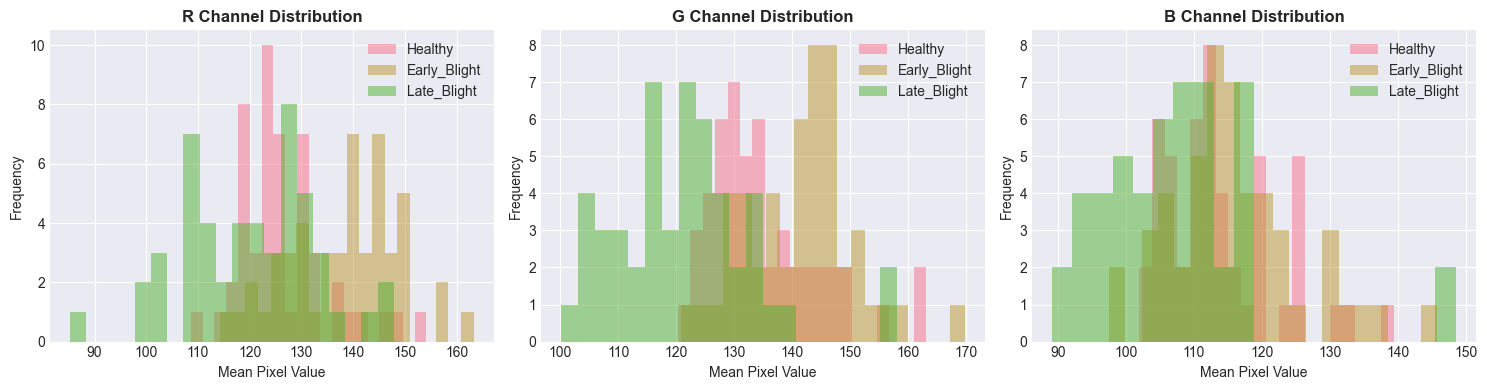

In [7]:
def analyze_color_distribution(data_dir, split='train', n_samples=50):
    """
    Analyze RGB color distributions for each class
    """
    colors_by_class = {class_name: {'R': [], 'G': [], 'B': []} for class_name in class_names}
    
    for class_name in class_names:
        class_dir = data_dir / split / class_name
        images = list(class_dir.glob('*'))[:n_samples]
        
        for img_path in images:
            img = Image.open(img_path).resize((224, 224))
            img_array = np.array(img)
            
            colors_by_class[class_name]['R'].append(img_array[:, :, 0].mean())
            colors_by_class[class_name]['G'].append(img_array[:, :, 1].mean())
            colors_by_class[class_name]['B'].append(img_array[:, :, 2].mean())
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    colors = ['red', 'green', 'blue']
    channels = ['R', 'G', 'B']
    
    for idx, (channel, color) in enumerate(zip(channels, colors)):
        for class_name in class_names:
            values = colors_by_class[class_name][channel]
            axes[idx].hist(values, alpha=0.5, label=class_name, bins=20)
        
        axes[idx].set_title(f'{channel} Channel Distribution', fontweight='bold')
        axes[idx].set_xlabel('Mean Pixel Value')
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()

analyze_color_distribution(data_dir, split='train', n_samples=50)

## Summary

This notebook explored:
1. Dataset statistics and class distribution
2. Sample images from each class
3. Image properties (dimensions, aspect ratios)
4. Data augmentation techniques
5. Color distribution analysis

Next steps:
- Train models using `train.py`
- Evaluate on test set
- Compare model performances